In [4]:
import pandas as pd
import statsmodels.api as sm
import re
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.formula.api import logit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
from imblearn.over_sampling import SMOTE

In [5]:
full_dataset = pd.read_csv('archive/Loan_status_2007-2020Q3.gzip')

In [6]:
full_dataset.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)

In [7]:
full_dataset['issue_d'] = pd.to_datetime(full_dataset['issue_d'])
mask = (full_dataset['issue_d'] > '2014-01-01') & (full_dataset['issue_d'] <= '2015-01-01')
small_dataset = full_dataset[mask]

In [8]:
columns = ['annual_inc', 'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'funded_amnt', 
           'home_ownership', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'pub_rec',
           'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'term', 'total_acc', 'verification_status', 'loan_status']
df = small_dataset[columns]


In [9]:
df['loan_status'].unique()

array(['Charged Off', 'Fully Paid', 'Current', 'Late (31-120 days)',
       'Default', 'In Grace Period'], dtype=object)

In [10]:
df['purpose'].unique()

array(['credit_card', 'debt_consolidation', 'car', 'house',
       'home_improvement', 'other', 'medical', 'major_purchase', 'moving',
       'vacation', 'small_business', 'renewable_energy', 'wedding'],
      dtype=object)

In [11]:
def clean_data(X):
    X = X.dropna()
    X['emp_length'] = [float(re.sub('[a-zA-Z +<]*', '', str(string))) for string in X['emp_length']]
    X['int_rate'] = [float(re.sub('[a-zA-Z %]*', '', str(string))) for string in X['int_rate']]
    X['term'] = [float(re.sub('[a-zA-Z ]*', '', str(string))) for string in X['term']]
    X['home_ownership'] = (X['home_ownership'] == 'OWN').astype('int')
    X['verification_status'] = (X['verification_status'] != 'Verified') | (X['verification_status'] != 'Source Verified')
    X['verification_status'] = X['verification_status'].astype('int')
    # Remove emp title, issue_d before regression is run, can also try get_dummies for emp_title (Maybe just a few professions or types)
    # Drop funded amount since it is equal to loan amount for our data (Makes matrix singular), all are verified 
    X = X.drop(columns=['emp_title', 'issue_d','funded_amnt', 'verification_status'])
    
    
    #X['loan_status'] = (X['loan_status'] == 'Current') | (X['loan_status'] == 'Fully Paid') | (X['loan_status'] == 'In Grace Period')
    
#     There are so few defaults that instead I think we should do if the loan is paid/current
    mask = (X['loan_status'] == 'Default') | (X['loan_status'] == 'Fully Paid') | (X['loan_status'] == 'Charged Off')
    X = X[mask]
    X['loan_status'] = (X['loan_status'] == 'Default') | (X['loan_status'] == 'Charged Off')
    X['loan_status'] = X['loan_status'].astype('int')
    
    
    
    #Just select the categorical variables
    cat_vars = ['purpose']

    #Create dummy variables for each cat. variable
    for var in cat_vars:
        cat_list = pd.get_dummies(X[var], prefix=var)
        # Categorical variables that have low count are making matrix singular
        for col in cat_list.columns:
            if sum(cat_list[col]) <= 50:
                cat_list = cat_list.drop(columns=[col])
        X=X.join(cat_list)
        
        

    X = X.drop(columns = cat_vars)
    
    return X
  


In [12]:
# Wrote own function to preserve column names
def normalize(X):
    return (X-X.min())/(X.max()-X.min())

In [13]:
df = clean_data(df[:100000])

<ipython-input-11-1c91b5502a01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['emp_length'] = [float(re.sub('[a-zA-Z +<]*', '', str(string))) for string in X['emp_length']]
<ipython-input-11-1c91b5502a01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['int_rate'] = [float(re.sub('[a-zA-Z %]*', '', str(string))) for string in X['int_rate']]
<ipython-input-11-1c91b5502a01>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [14]:
df

,annual_inc,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
1485415,58000.0,0.0,0.0,14.92,8.0,0,2.0,321.08,6.99,10400.0,...,0,0,0,0,0,0,0,0,0,0
1485416,78000.0,0.0,0.0,12.03,10.0,0,0.0,336.64,12.39,15000.0,...,1,0,0,0,0,0,0,0,0,0
1485417,69000.0,0.0,0.0,25.81,10.0,0,0.0,326.53,13.66,9600.0,...,1,0,0,0,0,0,0,0,0,0
1485418,125000.0,0.0,1.0,8.31,10.0,0,0.0,319.08,17.14,12800.0,...,0,0,0,0,0,0,0,0,0,0
1485419,63800.0,0.0,0.0,18.49,6.0,0,0.0,516.36,15.59,21425.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585410,73000.0,0.0,0.0,16.95,7.0,0,0.0,626.90,15.61,26000.0,...,1,0,0,0,0,0,0,0,0,0
1585411,48000.0,0.0,0.0,12.25,10.0,0,0.0,261.64,14.99,11000.0,...,0,0,0,0,0,0,0,0,0,0
1585412,96000.0,0.0,0.0,9.74,2.0,0,0.0,694.20,11.67,21000.0,...,0,0,0,0,0,0,0,0,0,0
1585413,85000.0,0.0,0.0,20.40,1.0,0,0.0,274.97,10.99,8400.0,...,0,0,0,0,0,0,1,0,0,0


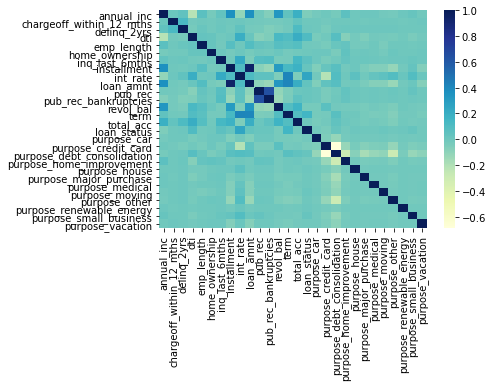

In [77]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, cmap="YlGnBu",xticklabels=True, yticklabels=True)
plt.show()

In [ ]:
X['annual_inc']*X['revol_ba']
X['loan_amnt']*X['annual_inc']
X['loan_amnt']*X['term']
X['term'] * X['pub_rec']


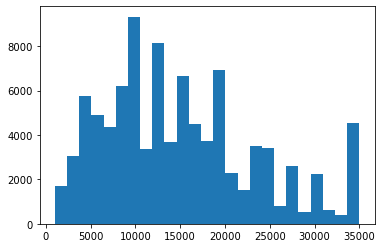

In [16]:
plt.hist(df['loan_amnt'], bins=25)
plt.show()

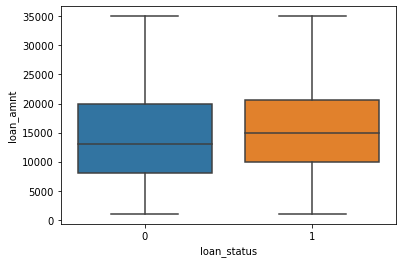

In [17]:
ax = sn.boxplot(y=df['loan_amnt'], x=df['loan_status'])

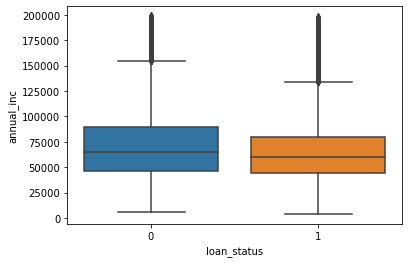

In [18]:
boxplot_df = df[df['annual_inc'] < 2*10**5] 
ax = sn.boxplot(y=boxplot_df['annual_inc'], x=boxplot_df['loan_status'])

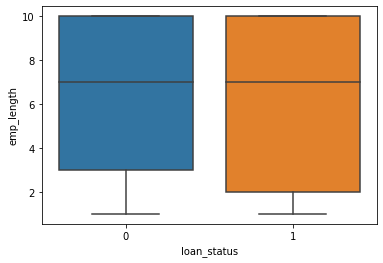

In [19]:
ax = sn.boxplot(y=df['emp_length'], x=df['loan_status'])

In [20]:
df.describe()

,annual_inc,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
count,9.468000e+04,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,...,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000,94680.000000
mean,7.606572e+04,0.010213,0.347740,18.687340,6.148638,0.098363,0.622560,441.368068,13.256667,15053.601869,...,0.620522,0.050718,0.003338,0.016698,0.009495,0.006401,0.047095,0.000708,0.008978,0.004721
std,5.886746e+04,0.110837,0.911921,8.500405,3.549273,0.297806,0.915047,244.774873,4.391549,8518.769795,...,0.485260,0.219423,0.057675,0.128139,0.096980,0.079747,0.211844,0.026592,0.094324,0.068549
min,4.000000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,30.420000,6.000000,1000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.600000e+04,0.000000,0.000000,12.270000,3.000000,0.000000,0.000000,264.460000,10.150000,8400.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.500000e+04,0.000000,0.000000,18.120000,7.000000,0.000000,0.000000,384.340000,12.990000,13500.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000e+04,0.000000,0.000000,24.630000,10.000000,0.000000,1.000000,578.420000,15.610000,20000.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.500000e+06,4.000000,22.000000,39.990000,10.000000,1.000000,6.000000,1408.130000,26.060000,35000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
train, test = train_test_split(df, train_size=0.80, random_state=1)
train = train.fillna(0)
test = test.fillna(0)
X = train.drop(columns=['loan_status'])
# Normalize Data (Using min max)
X = normalize(X)
# Note: Could also try multinomial logistic regression since the loan status doesnt necessarily have to be 0 or 1
# Perhaps cluster robust estimator by loan purpose or some other variable
Y = train['loan_status']
# Add regulariztion since otherwise with the normalized variables it wont converge
log_reg = sm.Logit(Y, X).fit_regularized()
clf = LogisticRegression(class_weight = 'balanced').fit(X,Y)
# results = log_reg

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4325799699396384
            Iterations: 237
            Function evaluations: 237
            Gradient evaluations: 237


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                75744
Model:                          Logit   Df Residuals:                    75717
Method:                           MLE   Df Model:                           26
Date:                Tue, 11 May 2021   Pseudo R-squ.:                 0.07611
Time:                        16:13:05   Log-Likelihood:                -32765.
converged:                       True   LL-Null:                       -35465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
annual_inc                    -5.9826      2.212     -2.704      0.007     -10.319      -1.647
chargeoff_within_12_mths       0.3378      0.339      0.996      0.319      -0.327       1.002
delinq_2yrs                    0.1491      0.240      0.622      0.534      -0.321       0.619
dti                            0.8017      0.052     15.335      0.000       0.699       0.904
emp_length                    -0.0769      0.025     -3.023      0.003      -0.127      -0.027
home_ownership                -0.0020      0.033     -0.060      0.952      -0.067       0.063
inq_last_6mths                 0.2956      0.065      4.572      0.000       0.169       0.422
installment                    1.5148      0.353      4.287      0.000       0.822       2.207
int_rate                       2.2932      0.067     34.162      0.000       2.162       2.425
loan_amnt                     -1.0712      0.273     -3.929      0.000      -1.606      -0.537
pub_rec                        0.9732      0.394      2.468      0.014       0.200       1.746
pub_rec_bankruptcies           0.6729      0.408      1.650      0.099      -0.127       1.472
revol_bal                    -12.1973      1.722     -7.083      0.000     -15.573      -8.822
term                           0.5395      0.052     10.351      0.000       0.437       0.642
total_acc                     -0.0851      0.109     -0.779      0.436      -0.299       0.129
purpose_car                   -3.3290      0.138    -24.175      0.000      -3.599      -3.059
purpose_credit_card           -2.8813      0.044    -64.888      0.000      -2.968      -2.794
purpose_debt_consolidation    -2.9236      0.043    -67.844      0.000      -3.008      -2.839
purpose_home_improvement      -2.9513      0.061    -48.152      0.000      -3.071      -2.831
purpose_house                 -3.2965      0.166    -19.829      0.000      -3.622      -2.971
purpose_major_purchase        -2.8136      0.085    -32.966      0.000      -2.981      -2.646
purpose_medical               -2.9460      0.108    -27.380      0.000      -3.157      -2.735
purpose_moving                -2.8392      0.120    -23.625      0.000      -3.075      -2.604
purpose_other                 -3.0733      0.061    -49.980      0.000      -3.194      -2.953
purpose_renewable_energy      -2.4524      0.308     -7.965      0.000      -3.056      -1.849
purpose_small_business        -2.7329      0.099    -27.486      0.000      -2.928      -2.538
purpose_vacation              -2.9149      0.148    -19.704      0.000      -3.205      -2.625
==============================================================================================
"""

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.505


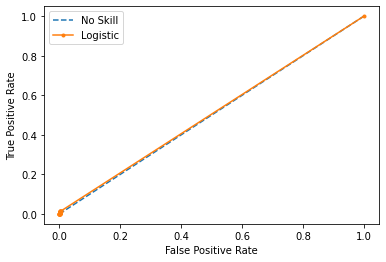

In [23]:
# TO-DO: Precision Recall is better since we have a large class imbalance 
X_test = test.drop(columns=['loan_status'])
X_test = normalize(X_test)
y_test = test['loan_status']
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = log_reg.predict(X_test)
lr_probs = lr_probs.reset_index(drop=True)
lr_probs = lr_probs * (lr_probs > .5)
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [118]:
w = {0:1, 1:5}
clf = LogisticRegression(class_weight = w)
clf.fit(X,Y)
y_pred = clf.predict(X_test)


print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')


Accuracy Score: 0.6726341360371778
Confusion Matrix: 
[[10729  4785]
 [ 1414  2008]]
Area Under Curve: 0.6391801277961867
Recall score: 0.586791350087668


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic: f1=0.393 auc=0.323


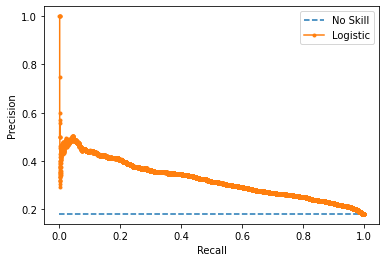

In [120]:
#Recall for weighted logistic regression 
lr_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig("recall_weighted_logistic_regression.png")
# show the legend
plt.legend()
# show the plot
plt.show()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.697


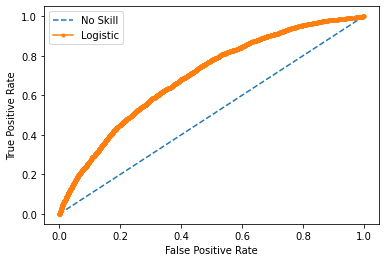

In [63]:
#ROC for weighted logistic rege

lr_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_probs[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.506


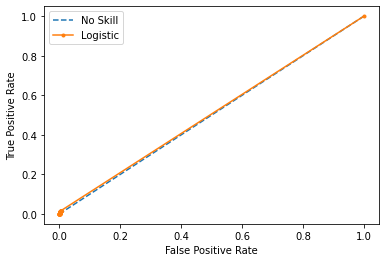

In [62]:
freq = (Y == 1)
freq[Y==1] = 8
freq[Y==0] = 1

res = GLM(Y,X,family=families.Binomial(link=families.links.probit()),var_weight = freq)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = res.fit().predict(X_test)
lr_probs = lr_probs.reset_index(drop=True)
lr_probs = lr_probs * (lr_probs > .5)
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [28]:
qda_model = QDA()
qda_model.fit(X,Y)
y_pred = (y_pred > 0.5).astype('int')
y_pred = qda_model.predict(X_test)

print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy Score: 0.2692754541613857
Confusion Matrix: 
[[ 2113 13401]
 [  436  2986]]
Area Under Curve: 0.5043943454252252
Recall score: 0.8725891291642315


In [29]:
param_grid = {
    'shrinkage': [1.0, 0, 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'solver': ['svd', 'lsqr', 'eigen']
}

gs = GridSearchCV(
    LDA(),
    param_grid=param_grid,
    verbose=1,
    cv=5,
    n_jobs=-1
)

lda_gs_results = gs.fit(X, Y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.69672848 0.69672848        nan 0.81952368 0.81952368
        nan 0.81951047 0.81951047        nan 0.81953688 0.81953688
        nan 0.8196293  0.8196293         nan 0.81952368 0.81952368
        nan 0.81952368 0.81952368        nan 0.81952368 0.81952368
        nan 0.81952368 0.81952368        nan 0.81952368 0.81952368]
  warnings.warn(


In [30]:
print("%-30s %4.10f" % ("LDA Best Score:", lda_gs_results.best_score_))
print("%-30s %4s"    % ("LDA Best Parameters:", lda_gs_results.best_params_))

LDA Best Score:                0.8196292970
LDA Best Parameters:           {'shrinkage': 0.001, 'solver': 'lsqr'}


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.698


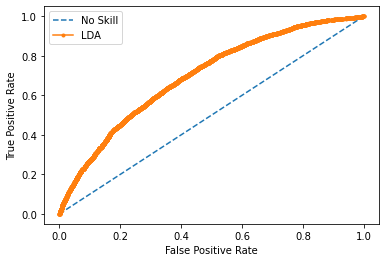

In [31]:
lda_model = LDA(shrinkage = 0.001, solver = 'lsqr')
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lda_model.fit(X,Y)
lr_probs = lda_model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Logistic: f1=0.106 auc=0.324


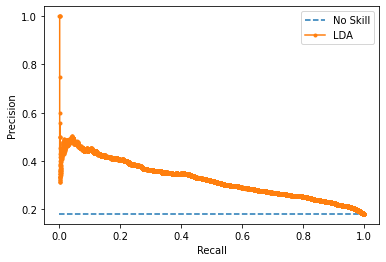

In [127]:
lda_model = LDA(shrinkage = 0.001, solver = 'lsqr')
ns_probs = [0 for _ in range(len(y_test))]
lda_model.fit(X,Y)
lr_probs = lda_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
y_pred = lda_model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='LDA')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.savefig("recall_LDA.png")
# show the plot
plt.show()

In [33]:
param_grid = {
    'reg_param': [0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0, 2.0],
    'tol': [0.0001]
}

gs = GridSearchCV(
    QDA(),
    param_grid=param_grid,
    verbose=1,
    cv=5,
    n_jobs=-1
)

qda_gs_results = gs.fit(X, Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [34]:
print("%-30s %4.10f" % ("QDA Best Score:", qda_gs_results.best_score_))
print("%-30s %4s"    % ("QDA Best Parameters:", qda_gs_results.best_params_))

QDA Best Score:                0.8220849177
QDA Best Parameters:           {'reg_param': 0.1, 'tol': 0.0001}


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.498


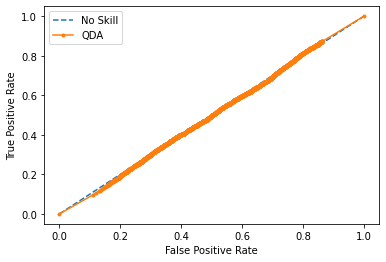

In [125]:
qda_model = QDA()
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = qda_model.fit(X,Y)
lr_probs = qda_model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
lr_probs = lr_probs*(lr_probs>0.5)
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='QDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.558


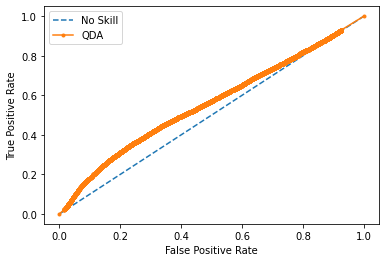

In [113]:
#ROC qda training test

qda_model = QDA()
ns_probs = [0 for _ in range(len(Y))]
lr_probs = qda_model.fit(X,Y)
lr_probs = qda_model.predict_proba(X)
lr_probs = lr_probs[:,1]
lr_probs = lr_probs*(lr_probs>0.5)
ns_auc = roc_auc_score(Y, ns_probs)
lr_auc = roc_auc_score(Y, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='QDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Logistic: f1=0.301 auc=0.218


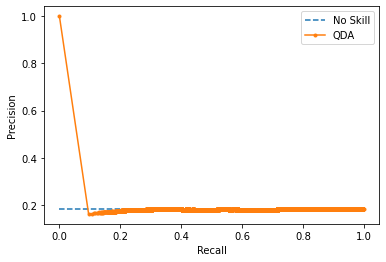

In [128]:
#Recall QDA 

qda_model = QDA()
ns_probs = [0 for _ in range(len(y_test))]
qda_model.fit(X,Y)
lr_probs = qda_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
y_pred = qda_model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='QDA')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.savefig("recall_QDA.png")
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4325799699396384
            Iterations: 237
            Function evaluations: 237
            Gradient evaluations: 237
325


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.696


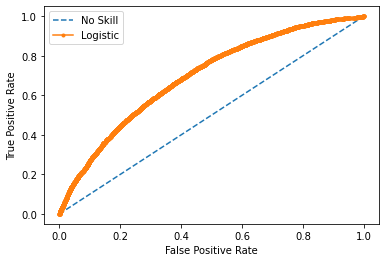

In [36]:
log_reg = sm.Logit(Y, X).fit_regularized()
pos_coef = np.abs(log_reg.params)
interaction = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
X1 = pd.DataFrame(interaction.fit_transform(X[pos_coef.nlargest(25).index]),columns=interaction.get_feature_names(X.columns.to_list()))
X1.index = Y.index
print(X1.shape[1])
X1_test = pd.DataFrame(interaction.fit_transform(X_test[pos_coef.nlargest(25).index]),columns=interaction.get_feature_names(X_test.columns.to_list()))
X1_test.index = X_test.index

clf = LogisticRegression()
clf.fit(X1,Y)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X1_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4325799699396384
            Iterations: 237
            Function evaluations: 237
            Gradient evaluations: 237


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic: f1=0.389 auc=0.317


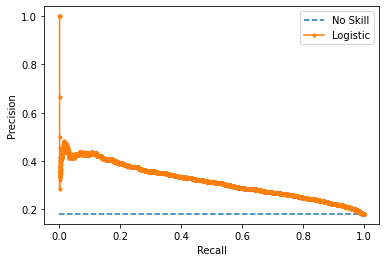

In [122]:
#Recall for weighted regression with interactions terms

log_reg = sm.Logit(Y, X).fit_regularized()
pos_coef = np.abs(log_reg.params)
interaction = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
X1 = pd.DataFrame(interaction.fit_transform(X[pos_coef.nlargest(27).index]),columns=interaction.get_feature_names(X.columns.to_list()))
X1.index = Y.index
X1_test = pd.DataFrame(interaction.fit_transform(X_test[pos_coef.nlargest(27).index]),columns=interaction.get_feature_names(X_test.columns.to_list()))
X1_test.index = X_test.index

w = {0:1,1:5}
clf = LogisticRegression(class_weight = w)
clf.fit(X1,Y)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X1_test)
y_pred = clf.predict(X1_test)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()



/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.697


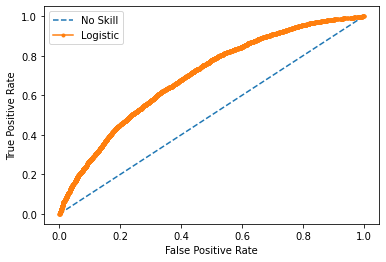

In [83]:

X1 = pd.DataFrame.copy(X)
X1['annual_inc/revol_bal'] = X['annual_inc']*X['revol_bal']
X1['loan_amnt/annual_inc'] = X['loan_amnt']*X['annual_inc']
X1['loan_amnt/term'] = X['loan_amnt']*X['term']
X1['pub_rec/term'] = X['term'] * X['pub_rec']

X1_test = pd.DataFrame.copy(X_test)
X1_test['annual_inc/revol_bal'] = X_test['annual_inc']*X_test['revol_bal']
X1_test['loan_amnt/annual_inc'] = X_test['loan_amnt']*X_test['annual_inc']
X1_test['loan_amnt/term'] = X_test['loan_amnt']*X_test['term']
X1_test['pub_rec/term'] = X_test['term'] * X_test['pub_rec']

clf = LogisticRegression()
clf.fit(X1,Y)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X1_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic: f1=0.391 auc=0.322


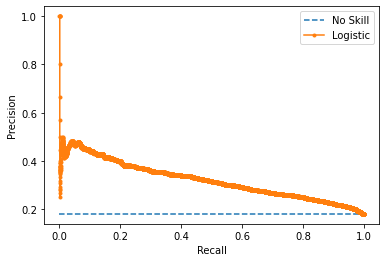

In [123]:

X1 = pd.DataFrame.copy(X)
X1['annual_inc/revol_bal'] = X['annual_inc']*X['revol_bal']
X1['loan_amnt/annual_inc'] = X['loan_amnt']*X['annual_inc']
X1['loan_amnt/term'] = X['loan_amnt']*X['term']
X1['pub_rec/term'] = X['term'] * X['pub_rec']

X1_test = pd.DataFrame.copy(X_test)
X1_test['annual_inc/revol_bal'] = X_test['annual_inc']*X_test['revol_bal']
X1_test['loan_amnt/annual_inc'] = X_test['loan_amnt']*X_test['annual_inc']
X1_test['loan_amnt/term'] = X_test['loan_amnt']*X_test['term']
X1_test['pub_rec/term'] = X_test['term'] * X_test['pub_rec']


w = {0:1,1:5}
clf = LogisticRegression(class_weight = w)
clf.fit(X1,Y)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X1_test)
y_pred = clf.predict(X1_test)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()


In [87]:

print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')


Accuracy Score: 0.8184410646387833
Confusion Matrix: 
[[15393   121]
 [ 3317   105]]
Area Under Curve: 0.5114422018249085
Recall score: 0.030683810637054353


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4325799699396384
            Iterations: 237
            Function evaluations: 237
            Gradient evaluations: 237


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic: f1=0.046 auc=0.324


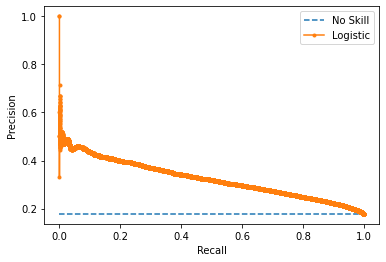

In [74]:
log_reg = sm.Logit(Y, X).fit_regularized()
pos_coef = np.abs(log_reg.params)
interaction = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
X1 = pd.DataFrame(interaction.fit_transform(X[pos_coef.nlargest(27).index]),columns=interaction.get_feature_names(X.columns.to_list()))
X1.index = Y.index
X1_test = pd.DataFrame(interaction.fit_transform(X_test[pos_coef.nlargest(27).index]),columns=interaction.get_feature_names(X_test.columns.to_list()))
X1_test.index = X_test.index

w = {0:1,1:1}
clf = LogisticRegression(class_weight = w)
clf.fit(X1,Y)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X1)
y_pred = clf.predict(X1)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(Y, lr_probs)
lr_f1, lr_auc = f1_score(Y, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Y[Y==1]) / len(Y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()


In [40]:
# summarize class distribution
counter = Counter(Y)
print(counter)
# transform the dataset
oversample = SMOTE()
X2, Y2 = oversample.fit_resample(X, Y)
# summarize the new class distribution
counter = Counter(Y2)
print(counter)




Counter({0: 62268, 1: 13476})
Counter({0: 62268, 1: 62268})


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.696


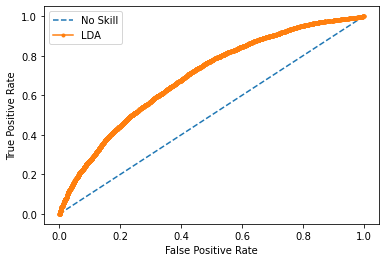

In [133]:
#ROC on test and oversample LDA 


lda_model = LDA(shrinkage = 0.001, solver = 'lsqr')
ns_probs = [0 for _ in range(len(y_test))]
lda_model.fit(X2,Y2)
lr_probs = lda_model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig("ROC_oversampled_LDA.png")
# show the plot
plt.show()

Logistic: f1=0.389 auc=0.324


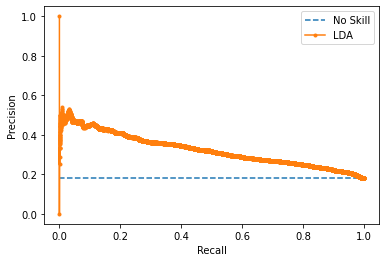

In [132]:
#Recall on test and oversample LDA 

lda_model = LDA(shrinkage = 0.001, solver = 'lsqr')
ns_probs = [0 for _ in range(len(y_test))]
lda_model.fit(X2,Y2)
lr_probs = lda_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
y_pred = lda_model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='LDA')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.savefig("recall_oversampled_LDA.png")
# show the plot
plt.show()

/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.639


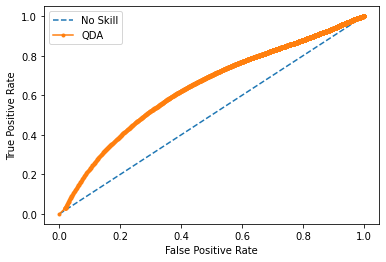

In [129]:
#ROC on train and oversample QDA
qda_model = QDA()
ns_probs = [0 for _ in range(len(Y2))]
qda_model.fit(X2,Y2)
lr_probs = qda_model.predict_proba(X2)
lr_probs = lr_probs[:,1]
ns_auc = roc_auc_score(Y2, ns_probs)
lr_auc = roc_auc_score(Y2, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y2, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y2, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='QDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Logistic: f1=0.307 auc=0.227


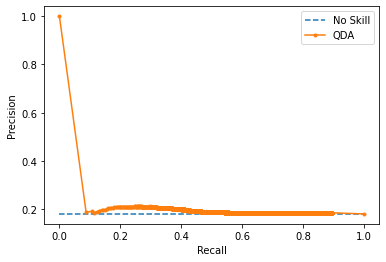

In [100]:
#Recall test and oversampled data 

qda_model = QDA()
ns_probs = [0 for _ in range(len(y_test))]
qda_model.fit(X2,Y2)
lr_probs = qda_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_probs = lr_probs *(lr_probs >0.5)
y_pred = qda_model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='QDA')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Logistic: f1=0.666 auc=0.626


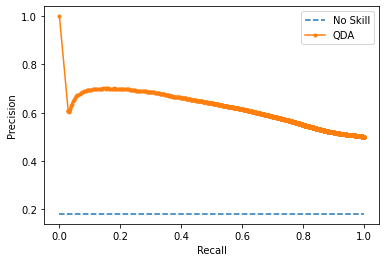

In [134]:
#Recall train and oversampled data

qda_model = QDA()
ns_probs = [0 for _ in range(len(Y2))]
qda_model.fit(X2,Y2)
lr_probs = qda_model.predict_proba(X2)
lr_probs = lr_probs[:, 1]
y_pred = qda_model.predict(X2)
lr_precision, lr_recall, _ = precision_recall_curve(Y2, lr_probs)
lr_f1, lr_auc = f1_score(Y2, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='QDA')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.savefig('oversampled_trainig_QDA.png')
# show the plot
plt.show()

In [130]:

print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.2692754541613857
Confusion Matrix: 
[[ 2113 13401]
 [  436  2986]]
Area Under Curve: 0.5043943454252252
Recall score: 0.8725891291642315
